# Word-level GMM Error Detector

In [21]:
import sklearn.mixture
import numpy as np
import torch
import sys
sys.path.insert(0, "../")
import pprint
pp = pprint.PrettyPrinter()

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
%matplotlib inline

from utils import timed_func

In [2]:
# Load BEA sentences to train GMM
@timed_func
def parse_grammar_dataset():
    m2_path = "../data/BEA14/WI_LOCNESS/wi+locness/m2/A.train.gold.bea19.m2"
    with open(m2_path, "r") as f:
        raw_lines = f.readlines()

    data = []
    curr_item = {}
    for line in raw_lines:
        if line.startswith("S "):
            if len(curr_item) > 0 and len(curr_item["errors"]) > 0:
                curr_item["corrected_sent"] = _correct_sentence(curr_item)
                data.append(curr_item)
            curr_item = {"sentence": line[2:], "errors": []}
        elif line.startswith("A "):
            items = line.split("|||")
            start_pos_str, end_pos_str = items[0][2:].split()
            start_pos, end_pos = int(start_pos_str), int(end_pos_str)
            error = {
                "start_pos": start_pos,  # These are in terms of word locs
                "end_pos": end_pos,
                "correct": items[2] 
            }
            curr_item["errors"].append(error)

    print("Collected {} sentences".format(len(data)))
    sentences = [item['sentence'] for item in data]
    return data, sentences 

def _correct_sentence(item):
    """
    E.g., sent is "My town is a medium size city ..."
    errors is [{'start_pos': 5, 'end_pos': 6, 'correct': '- sized'}]
    Assume errors are sorted by start_pos.
    """
    sent = item['sentence']
    L = sent.split()
    newline = []
    i = 0
    for err in item['errors']:
        if err['start_pos'] == -1:  # This sentence is correct
            return sent
        newline.extend(L[i:err['start_pos']])
        newline.append(err['correct'])
        i = err['end_pos']
    newline.extend(L[i:])
    return " ".join(newline)
    
gec_data, gec_sentences = parse_grammar_dataset()

Collected 10492 sentences
parse_grammar_dataset done in 0.22 seconds.


In [3]:
gec_data[0]

{'sentence': 'My town is a medium size city with eighty thousand inhabitants .\n',
 'errors': [{'start_pos': 5, 'end_pos': 6, 'correct': '- sized'}],
 'corrected_sent': 'My town is a medium - sized city with eighty thousand inhabitants .'}

In [4]:
gec_samples = np.random.choice(gec_data, 1000)
gec_correct_sentences_train = [item['corrected_sent'] for item in gec_samples[:500]]
gec_correct_sentences_train[:10]

['I agree with your parents , maybe you could spend your money on something you really need and maybe you can buy computer games with the money you have left , or maybe you could put aside the money to buy something really important to you .',
 'First of all , a boat travels on the sea and the sea is very beautiful .',
 'I am so happy you have finally decided to visit my country .\n',
 'After the exams finished , I went home and had nothing to do , so I thought that I needed to watch my dramas because it was a week since I had watched them due to the exam week .',
 'Washing you enjoy it .',
 "They 're more for self - defense , but  what I do , and my way to stay healthy , is martial arts and running .",
 'We were very happy there . We really liked Taxco .',
 'The future of transport is  public , because there will be less traffic .',
 'I am writing to apply for the job of camp organizer .\n',
 "Hi Alex , I ca n't wait   to see you"]

## Word-level encoder

In [5]:
from transformers import AutoTokenizer, AutoModel
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [6]:
#sent = "An apple a day keeps the doctors away"
sent = "An idealistic opportunity does n't always lead to success."
tokens = tokenizer.tokenize(sent)
tokens

['An',
 'Ġideal',
 'istic',
 'Ġopportunity',
 'Ġdoes',
 'Ġn',
 "'t",
 'Ġalways',
 'Ġlead',
 'Ġto',
 'Ġsuccess',
 '.']

In [7]:
class SentEncoder:
    def __init__(self, model_name='roberta-base'):
        self.model_name = model_name
        self.auto_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.auto_model = AutoModel.from_pretrained(model_name)

    def encode_vecs_per_word(self, sent, include_sos_eos=False):
        """
        Input: sent (str)
        Output: 
            tokens: list (n_words + 2) of str
            all_hids: torch.tensor (n_words + 2, 13, D), where 
                the additional 2 tokens are <s> and </s> that RoBERTa adds.
        """
        tokens = self.auto_tokenizer.tokenize(sent)
        start_of_word_positions = np.array(
            [i for i in range(len(tokens)) if tokens[i].startswith("Ġ") or i==0]
        )  
        word_tokens, start_of_word_positions = ['<s>'], []
        wt_buffer = []
        for i, t in enumerate(tokens):
            if i == 0:
                wt_buffer = [t]
                start_of_word_positions.append(i)
            elif t.startswith("Ġ"):
                # This is RoBERTa-specific
                # Except for the first word, all tokens that are start of words
                # are marked with a "Ġ".
                word_tokens.append("".join(wt_buffer))
                start_of_word_positions.append(i)
                wt_buffer = [t[1:]]
            else:
                wt_buffer.append(t)
        word_tokens.append("".join(wt_buffer))
        word_tokens.append('</s>')
        start_of_word_positions = 1 + np.array(start_of_word_positions)
        
        ids = torch.tensor(self.auto_tokenizer.encode(sent)).unsqueeze(0)
        final, last, hids = self.auto_model(ids, output_hidden_states=True)
        # hids is List (len 13) of torch.tensor (bsz=1, token_len+2, D)

        all_hids = []
        for layer in range(len(hids)):
            layer_hids = []
            
            i = 0
            for pos in start_of_word_positions.tolist() + [len(hids[0][0])]:
                vecs = torch.mean(hids[layer][0:1, i:pos,:], dim=1)
                layer_hids.append(vecs)
                i = pos
            layer_hids.append(hids[layer][0:1, -1, :])
            
            lh = torch.cat(layer_hids, dim=0).unsqueeze(0)
            all_hids.append(lh)
            
        all_hids = torch.cat(all_hids, dim=0).permute([1, 0, 2])
        if not include_sos_eos:
            return word_tokens[1:-1], all_hids[1:-1, :, :]
        else:
            return word_tokens, all_hids
    
    def contextual_token_vecs(self, sentences):
        """Returns: (similar shapes as src.sent_encoder.SentEncoder)
        ret_tokens: List[List[tokens]] one list for each sentence.
        ret_hids: List (len n. sentences) [np.array(n_words, 13, D=768)]
        """
        ret_tokens, ret_hids = [], []
        for sent in sentences:
            tokens, hids = self.encode_vecs_per_word(sent)
            ret_tokens.append(tokens)
            ret_hids.append(hids.detach().cpu().numpy())
        return ret_tokens, ret_hids
    

## Word-level grammar errors

Look at the locations where scores are the most extraordinary
(Let me do a token-level correlation)  
E.g.: One sentence has 5 tokens with grammar errors: at pos 1,2,3,5,4  
(1) The top 5 positions ranked by GMM surprisal scores, are 1,2,3,5,6  
Then the "token-level detection" accuracy would be 80%.  
(2) Is there a "threshold" for the GMM surprisal scores?

In [8]:
enc = SentEncoder()

In [9]:
#test_sent = "My town is a medium size city with eighty thousand inhabitants .\n"
test_sent = "An idealistic opportunity does n't work."
raw_tokens, vecs = enc.encode_vecs_per_word(test_sent)
print(len(raw_tokens), raw_tokens)
vecs.shape

6 ['An', 'idealistic', 'opportunity', 'does', "n't", 'work.']


torch.Size([6, 13, 768])

In [10]:
class AnomalyModel:
    """Model that uses GMM on embeddings generated by BERT for finding syntactic
    or semantic anomalies.
    """

    def __init__(self, train_sentences):
        self.enc = SentEncoder()
        self.gmms = []

        _, all_vecs = self.enc.contextual_token_vecs(train_sentences)
        for layer in range(13):
            sent_vecs = np.vstack([vs[:,layer,:] for vs in all_vecs])
            gmm = sklearn.mixture.GaussianMixture()
            gmm.fit(sent_vecs)
            self.gmms.append(gmm)


    def gmm_score(self, sentences):
        """Returns (all_tokens, all_scores), where
        all_tokens is List[List[token]]
        all_scores is List[np.array(num layers, |S|)]
        """

        all_tokens, all_vecs = self.enc.contextual_token_vecs(sentences)
        all_scores = []

        for sent_ix in range(len(sentences)):
            tokens = all_tokens[sent_ix]
            vecs = all_vecs[sent_ix]
            assert len(tokens) == vecs.shape[0]

            layer_scores = []
            for layer in range(13):
                scores = self.gmms[layer].score_samples(vecs[:, layer, :])
                layer_scores.append(scores)

            all_scores.append(np.array(layer_scores))
        return all_tokens, all_scores

In [11]:
anomaly_model = AnomalyModel(gec_correct_sentences_train)

In [12]:
test_samples = gec_samples[500:510]
test_sentences = [item['sentence'] for item in test_samples]
all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)

In [13]:
def all_layer_scores(sample):
    sent = sample['sentence']
    pp.pprint(sample)
    tokens, all_layer = anomaly_model.gmm_score([sent])
    tokens = tokens[0]
    all_layer = all_layer[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(all_layer, origin='lower')
    plt.xticks(range(len(tokens)), tokens, rotation='vertical')
    plt.yticks(range(12), range(12))
    plt.ylabel('Layer')
    plt.show()

{'corrected_sent': 'transport in Sudan is so expensive . We suffer from the '
                   'less and expensive transport here .',
 'errors': [{'correct': 'in', 'end_pos': 2, 'start_pos': 1},
            {'correct': '. We', 'end_pos': 7, 'start_pos': 6}],
 'sentence': 'transport at Sudan is so expensive we suffer from the less and '
             'expensive transport here .\n'}


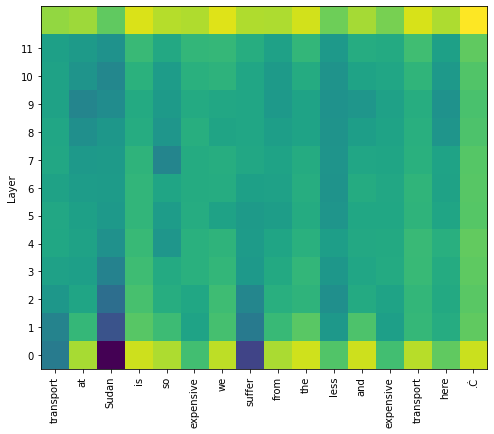

In [14]:
all_layer_scores(test_samples[0])

In [15]:
@timed_func
def verify_lengths(samples):
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    # Verify if the token lengths match sample sentence lengths

    equal = 0
    for i, sample in enumerate(samples):
        tr_word_len = len(all_tokens[i])  # Given by transformers
        st_word_len = len(test_sentences[i].split())  # Input sentence
        if tr_word_len == st_word_len:
            equal += 1
        #print("\ntr: {}, st: {}".format(tr_word_len, st_word_len))
        #print("tr: {}, st: {}".format(all_tokens[i], test_sentences[i].split()))
    print("Among {} samples, {} ({:.2f}%) have matched lens from two methods.".format(
        len(samples), equal, equal / len(samples) * 100
    ))
    
verify_lengths(gec_samples)

Among 1000 samples, 1000 (100.00%) have matched lens from two methods.
verify_lengths done in 129.23 seconds.


In [26]:
@timed_func
def true_false_bin(samples):
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    
    for layer in range(13):
        print ("=====Layer {}=====".format(layer))
        scores_correct, scores_typo = [], []
        for i, sample in enumerate(samples):
            if sample['errors'][0]['start_pos'] == -1:  # This sentence is correct
                scores_correct += gmm_scores[i][layer].tolist()
            else:
                # These T/F sentinels mark the errors of this sentence
                st_word_len = len(test_sentences[i].split())
                tr_word_len = len(all_tokens[i])
                assert tr_word_len == st_word_len  # Verified in verify_lengths. Safety check here
                
                sentinels = np.ones(st_word_len)
                for gerr in sample['errors']:
                    sentinels[gerr['start_pos']: gerr['end_pos']] = 0  # broadcast
                
                for j in range(len(sentinels)):
                    if sentinels[j]:
                        scores_correct.append(gmm_scores[i][layer,j])
                    else:
                        scores_typo.append(gmm_scores[i][layer,j])
        print ("Correct words (total {}): avg score: {:.2f}, std {:.2f}".format(
            len(scores_correct),
            np.mean(scores_correct), np.std(scores_correct)
        ))
        print ("Incorrect words (total {}): avg score: {:.2f}, std {:.2f}".format(
            len(scores_typo),
            np.mean(scores_typo), np.std(scores_typo)
        ))
        stat, p = mannwhitneyu(scores_correct, scores_typo)
        # https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
        # Non-normal for both arrays
        u_test_res = "Same" if p>0.05 else "Different"
        print ("Mann Whitney U test: p={}. {} distributions.".format(p, u_test_res))
        
true_false_bin(gec_samples[500:])

=====Layer 0=====
Correct words (total 7617): avg score: 234.68, std 625.88
Incorrect words (total 1402): avg score: 10.98, std 732.24
Mann Whitney U test: p=2.427541425815511e-26. Different distributions.
=====Layer 1=====
Correct words (total 7617): avg score: -126.04, std 357.21
Incorrect words (total 1402): avg score: -252.05, std 393.95
Mann Whitney U test: p=3.214187967009049e-33. Different distributions.
=====Layer 2=====
Correct words (total 7617): avg score: -163.72, std 264.42
Incorrect words (total 1402): avg score: -254.97, std 265.19
Mann Whitney U test: p=4.902447826084232e-37. Different distributions.
=====Layer 3=====
Correct words (total 7617): avg score: -145.88, std 214.49
Incorrect words (total 1402): avg score: -231.61, std 197.12
Mann Whitney U test: p=5.1862277392489386e-52. Different distributions.
=====Layer 4=====
Correct words (total 7617): avg score: -144.94, std 206.44
Incorrect words (total 1402): avg score: -226.60, std 175.94
Mann Whitney U test: p=1.667

## Observations up till now:  
1. There are separations between the GMM scores for "correct words" and "incorrect words".  
2. Except for layer 12, the `p` values in general decrease as layers go up. This might indicate that higher layers are more surprised at grammar errors.  
3. The large std indicate that there might not be a clear-cut threshold, for us to say "when the surprisal score is beyond / below this threshold, this is grammar error".  

## Word-level grammar error detection
- Can we tune on dev set to find a threshold?  
- Use this performance to contrast to the next step (residualization)

In [27]:
@timed_func
def find_threshold(samples):
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    
    # TODO - find threshold on gec_dev (TODO)

## Word-level grammar error detection with residualization

In [ ]:
@timed_func
def ged_with_residualization(samples):
    raise NotImplemented